# Visualized AIMD EXAFS from FEFF
Data courtesy of Micah Prange and Eugene Ilton

In [1]:
import utils
import wavelet_transform
from importlib import reload
from PIL import Image
from ipywidgets import *

utils = reload(utils)
wavelet_transform = reload(wavelet_transform)
from utils import *

## Get data and visualize

In [2]:
datafiles = os.listdir('Data/')
Data = np.array([read_file(f'Data/{filename}') for filename in datafiles])
kweight = 3
print(Data.shape)

(839, 414, 4)


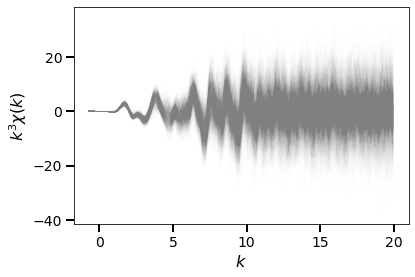

In [3]:
fig, ax = plt.subplots(figsize=(6, 4))
avg_k = np.average(Data[:, :, 0], axis=0)
avg_chi_of_k = np.average(Data[:, :, 1], axis=0)
std_of_chi = np.std(Data[:, :, 1], axis=0, ddof=1)

N = len(std_of_chi)

for run in Data:
    plt.plot(run[:, 0], run[:, 0]**kweight * run[:, 1], '-', c='gray', alpha=0.003)

#plt.plot(avg_k, avg_k**kweight * avg_chi_of_k, '-', c=plt.cm.tab20(2), alpha=1.)
#ax.fill_between(avg_k, avg_k**kweight * (avg_chi_of_k + 3 * std_of_chi / np.sqrt(N)),
#                avg_k**kweight * (avg_chi_of_k - 3 * std_of_chi / np.sqrt(N)),
#                color=plt.cm.tab20(0), alpha=0.9)
#plt.xlim(12, 17)

ax.tick_params(direction='out', width=2, length=8, which='major', labelsize=14)
ax.set_xlabel('$k$', fontsize=16)
ax.set_ylabel('$k^' + f'{kweight}' + '\chi(k)$', fontsize=16)
plt.show()

Notes:

Send a few wavelets (and avg) to Micah to identify paths -- what are first five paths? Do they make sense?

How to remove donuts if they're numerical artifacts?

Make picture global scale in intensity

UML/ clustering on wavelets (PCA preprocessing? Recon plots?)

Compare scree plot on spaghetti vs wavelet --> different PCs req? Jerry guesses 8 for wavelet?

Re vs Imag instead of mod?

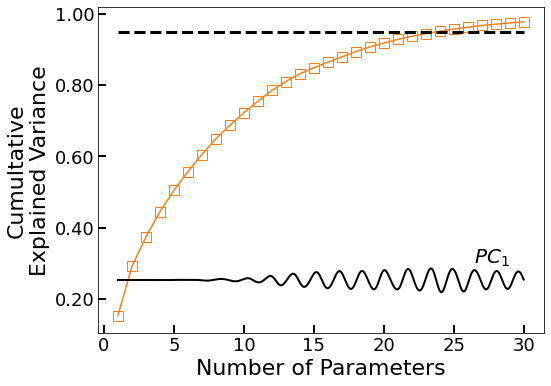

In [4]:
make_scree_plot(Data[:, :, 1] * Data[:, :, 0]**kweight, n=30, mod=5)

In [ ]:
Moduli = []
for i in range(len(Data)):
    print(i, end='\r')
    wavelet = wavelet_transform.cauchy_wavelet(Data[i, :, 0], chi=Data[i, :, 1], rmax_out=8, kweight=kweight)
    modulus = np.sqrt(wavelet.real**2 + wavelet.imag**2)
    Moduli.append(modulus)
Moduli = np.array(Moduli)
print(Moduli.shape)

382

In [ ]:
rmax_out = 8
wavelet = wavelet_transform.cauchy_wavelet(avg_k, chi=avg_chi_of_k, rmax_out=rmax_out, kweight=kweight)
modulus = np.sqrt(wavelet.real**2 + wavelet.imag**2) / max_mod

extent = [0, 1, 0, 1]

fig, axes = plt.subplots(figsize=(10, 5), ncols=2)
plt.subplots_adjust(wspace=0.35)

for i, ax in enumerate(axes):
    if i == 0:
        ax.imshow(modulus, origin='lower', extent=extent)
    else:
        ax.contour(modulus, extent=extent)

    ax.tick_params(direction='out', width=2, length=8, which='major', labelsize=14)
    set_axes(ax, min(avg_k), max(avg_k), nticks=4, axis='x')
    set_axes(ax, 0, rmax_out, nticks=5, axis='y')
    ax.set_ylabel("$R' (\AA) \; w_k=" + f'{kweight}' + "$", fontsize=16)
    ax.set_xlabel('$k (\AA^{-1})$', fontsize=16)

plt.show()

In [ ]:
fig, axes = plt.subplots(figsize=(10, 5), ncols=2)
plt.subplots_adjust(wspace=0.35)

def plot_contours(i, axes):
    for j, ax in enumerate(axes):
        if j == 0:
            img = ax.imshow(Moduli[i], origin='lower', extent=extent)
        else:
            contour = ax.contour(Moduli[i], extent=extent)

        ax.tick_params(direction='out', width=2, length=8, which='major', labelsize=14)
        set_axes(ax, min(avg_k), max(avg_k), nticks=4, axis='x')
        set_axes(ax, 0, rmax_out, nticks=5, axis='y')
        ax.set_ylabel("$R' (\AA) \; w_k=" + f'{kweight}' + "$", fontsize=16)
        ax.set_xlabel('$k (\AA^{-1})$', fontsize=16)
        
plot_contours(0, axes)

slider = IntSlider(min=0, max=len(Moduli), step=1, value=0, layout=widgets.Layout(width='70%'))
#@widgets.interact(i=slider)
def update(i):
    plot_contours(i, axes)
    fig.canvas.draw_idle()

#HBox([Label('$R_i$ '), slider]) 
interact(update, i=slider)
    
#def update(i = 0):
#    line.set_ydata(np.sin(w * x))
#    fig.canvas.draw_idle()

In [47]:
images = []
mods = []
for i in range(len(Data)):
    print(i, end='\r')
    wavelet = wavelet_transform.cauchy_wavelet(Data[i, :, 0], chi=Data[i, :, 1], rmax_out=8, kweight=kweight)
    modulus = np.sqrt(wavelet.real**2 + wavelet.imag**2)
    modulus = np.flip(modulus, axis=0)  # put origin in bottom left (not top left)
    img = Image.fromarray(np.uint8(plt.cm.viridis(modulus / max_mod) * 255))
    images.append(img)
    mods.append(modulus)

frame_one = images[0]
frame_one.save("wavelets_long_k_cubed.gif", format="GIF", append_images=images,
               save_all=True, duration=250, loop=0)  # duration in ms